# 3.1 Deconvolution

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_3_1 import MNIST_CNN
from utils import pixel_range

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/3_1_DC/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('DC', X)
    
    for activation in activations:
        tf.add_to_collection('DC', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.156623523 accuracy = 0.950163645
Epoch: 0002 cost = 0.042625537 accuracy = 0.986927283
Epoch: 0003 cost = 0.029875092 accuracy = 0.990618190
Epoch: 0004 cost = 0.021823779 accuracy = 0.993036370
Epoch: 0005 cost = 0.018047505 accuracy = 0.993927278
Epoch: 0006 cost = 0.013701927 accuracy = 0.995400004
Epoch: 0007 cost = 0.012501947 accuracy = 0.996018185
Epoch: 0008 cost = 0.010178409 accuracy = 0.996618185
Epoch: 0009 cost = 0.008392057 accuracy = 0.997272730
Epoch: 0010 cost = 0.008140020 accuracy = 0.997181821
Epoch: 0011 cost = 0.007686417 accuracy = 0.997581820
Epoch: 0012 cost = 0.006270998 accuracy = 0.998145456
Epoch: 0013 cost = 0.004811549 accuracy = 0.998509092
Epoch: 0014 cost = 0.007982755 accuracy = 0.997454548
Epoch: 0015 cost = 0.004931021 accuracy = 0.998309093
Accuracy: 0.9935


### 4. Restoring Subgraph

In [4]:
tf.reset_default_graph()

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, grad, tf.zeros(tf.shape(grad)))

sess = tf.InteractiveSession()

g = tf.get_default_graph()
with g.gradient_override_map({'Relu': 'GuidedRelu'}):
    new_saver = tf.train.import_meta_graph(ckptdir + '.meta')

new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

activations = tf.get_collection('DC')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='CNN')

X = activations[0]
activations = activations[1:]

sample_imgs = [images[np.argmax(labels, axis=1) == i][5] for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/2_3_DC/model


### 5. Displaying Images

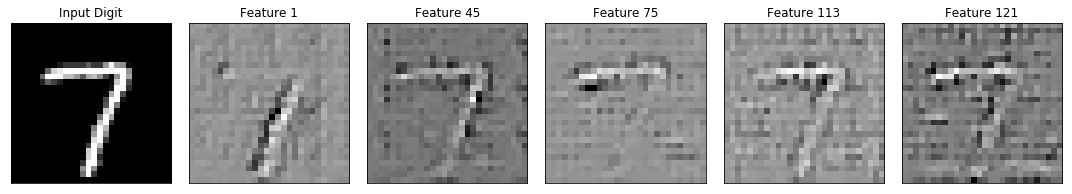

In [5]:
img_ind = 100

# Get indices for 5 feature maps with strongest activations
layer = sess.run(activations[6], feed_dict={X: images[None, img_ind]})

for i in range(3):
    layer = np.sum(layer, axis=0)

inds = np.sort(np.argpartition(layer, -4)[-5:])

figs = [images[None, img_ind]]

for ind in inds:
    deconv = tf.gradients(activations[6][:, :, :, None, ind], X)[0]
    r = sess.run(deconv, feed_dict={X: images[None, img_ind]})
    figs.append(r)

fig = plt.figure(figsize=(15,15))
for i in range(len(figs)):
    ax = fig.add_subplot(1, 6, i + 1)
    im = ax.imshow(figs[i].reshape(28,28), cmap='gray')
    
    if i is 0:
        ax.set_title('Input Digit')
    else:
        ax.set_title('Feature {}'.format(inds[i - 1]))
    
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()